# Raw data from policy-based self-play

We let the HeuristicPolicy play against itself to get some quick although not so high-quality training data. The policy and value evaluations stem from the heuristic policy itself.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import tensorflow as tf

from aegomoku.gomoku_game import GomokuGame
from aegomoku.gomoku_board import GomokuBoard
from aegomoku.policies.primary_detector import PrimaryDetector
from aegomoku.gomoku_game import RandomBoardInitializer
from aegomoku.policies.heuristic_policy import HeuristicPolicy
tf.config.list_physical_devices('GPU')

2022-08-20 20:58:14.861121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:14.861802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:14.867376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:14.868091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:14.868975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BOARD_SIZE=15
tight = HeuristicPolicy(15, .9)
loose = HeuristicPolicy(15, .4)
evaluator = HeuristicPolicy(15, 0,)
primary = PrimaryDetector(BOARD_SIZE)

# Initial board: 4 random stones in thw central square
rbi = RandomBoardInitializer(BOARD_SIZE, 4, 5, 9, 5, 9)
game = GomokuGame(BOARD_SIZE, initializer=rbi)

2022-08-20 20:58:14.929633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-20 20:58:15.075610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:15.076199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:15.076810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
def is_critical(state, value_threshold):
    current_player_policy = primary.call(state)[:, :, :, 3]
    other_player_policy = primary.call(state)[:, :, :, 4]
    current_max = np.max(current_player_policy, axis=None)
    other_max = np.max(other_player_policy, axis=None)
    return max(current_max, other_max) >= value_threshold

In [5]:
def create_sample(the_board: GomokuBoard):
    position = [stone.i for stone in the_board.stones]
    state = np.expand_dims(the_board.canonical_representation(), 0).astype(float)
    probs, value = evaluator.predict(state)
    probs = (np.array(probs)*255).astype(np.uint8)
    value = value.numpy()
    return position, probs, value

In [6]:
def one_game(verbose=False, value_threshold: int=0):
    game_data = []
    board = game.get_initial_board()
    players = [tight, loose]
    pointer = 0
    state = np.expand_dims(board.canonical_representation(), 0).astype(float)
    max_stones = 80
    num_stones = 0
    while tight.get_winner(state) is None and num_stones < max_stones:
        player = players[pointer]
        pointer = 1 - pointer
        num_stones += 1
        options = player.get_advisable_actions(state)
        move = random.choice(options)
        board.act(move)
        state = np.expand_dims(board.canonical_representation(), 0).astype(float)

        if tight.get_winner(state) is not None:
            break
        if is_critical(state, value_threshold):
            game_data.append(create_sample(board))
            if verbose:
                board.plot()
                print("MUST DEFEND")
    if num_stones < max_stones:
        if verbose:
            print([stone.i for stone in board.stones])
            print("GAME OVER")
    return game_data

In [67]:
data = []

In [68]:
for i in range(200):
    data += one_game(value_threshold=900)

In [69]:
from aegomoku.game_data import expand_trajectory

examples = expand_trajectory(game, BOARD_SIZE, data)
len(examples), len(examples[0]), examples[0][0].shape

(1424, 3, (17, 17, 3))

Next to play: BLACK
Value from BLACK's point of view: 0.9357343821281586


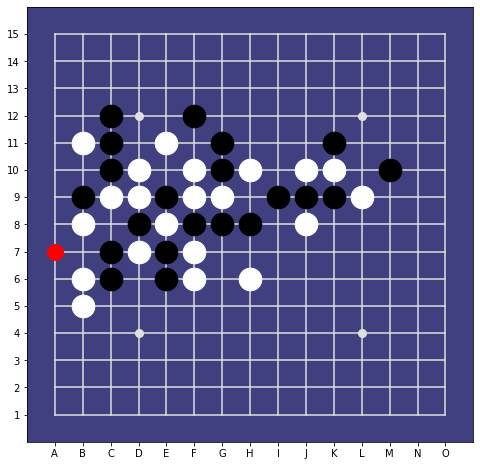

In [111]:
from aegomoku.utils import analyse_example

analyse_example(BOARD_SIZE, examples[random.randint(0, len(examples))])

---

In [112]:
from pickle import Pickler

with open("trajectories/policy/terminal_opportunities.pickle", 'wb+') as f:
    Pickler(f).dump(data)

In [54]:
from aegomoku.game_data import read_training_data

BOARD_SIZE=15
filename = "trajectories/policy/loose_60000.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape

(59760, 3, (17, 17, 3))

Next to play: BLACK
Value from BLACK's point of view: 0.037810646601737295


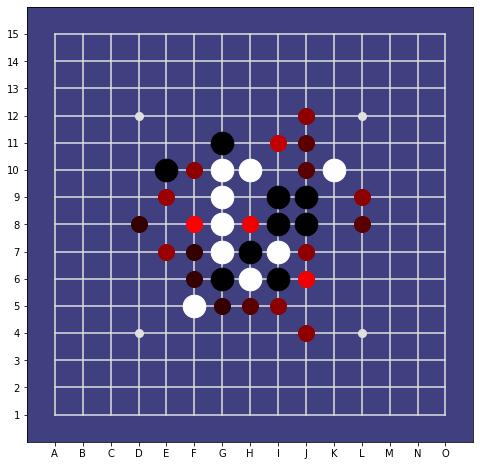

In [66]:
from aegomoku.utils import analyse_example

analyse_example(BOARD_SIZE, examples[random.randint(0, len(examples))])

# Trying various architectures

Here's the point where we will need to look into different architectures

A suitable candidate should (in that order)
- easily overfit a small number of examples
- remain convergent for growing number of examples
- eventually generalize to unseen examples

In [8]:
from aegomoku.gomoku_model import NeuralNetAdapter

the_model = NeuralNetAdapter(BOARD_SIZE + 2)
the_model.policy.compile()

In [9]:
N=50
the_model.train(examples[:N], epochs_per_train=1000, report_every=100)

Epoch: 1, Training: 5.987297058105469, Test: 0.0
Epoch: 101, Training: 5.379342555999756, Test: 0.0
Epoch: 201, Training: 5.346553802490234, Test: 0.0
Epoch: 301, Training: 5.335482597351074, Test: 0.0
Epoch: 401, Training: 5.329912185668945, Test: 0.0
Epoch: 501, Training: 5.32656717300415, Test: 0.0
Epoch: 601, Training: 5.324337959289551, Test: 0.0
Epoch: 701, Training: 5.322741508483887, Test: 0.0
Epoch: 801, Training: 5.321686744689941, Test: 0.0
Epoch: 901, Training: 5.3207621574401855, Test: 0.0
Epochs: 1000, Loss: 5.320000648498535, 


(1, 17, 17, 3)
n=79
Next to play: WHITE
Value from WHITE's point of view: -0.5832451270483647
value = -0.5832451270483647
Next to play: WHITE
Value from WHITE's point of view: [[-0.5864592]]
value = [[-0.5864592]]


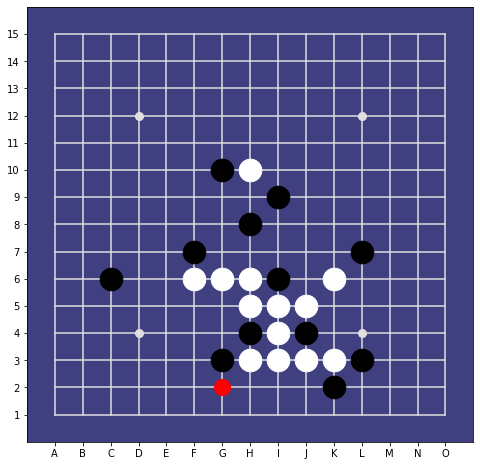

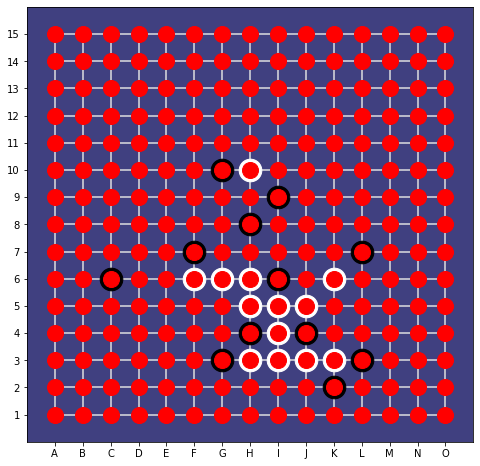

In [10]:
n = random.randint(0, 2*N)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
print(sample.shape)
p_, v_ = the_model.policy(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), v_)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
print(f"value = {v}")
analyse_example(BOARD_SIZE, example)
print(f"value = {v_}")